In [ ]:
import time
import os
import sys
import ok
from imp import reload
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

# Setup the directories
cwd = os.getcwd()
OK_DIR = os.path.dirname(cwd)

sys.path.append(os.path.join(OK_DIR, 'python'))
import dac_control as dac
import adc_control as adc
import spi_control as spi
import wupdate_control as wupdate
import neuron_control as neuron
import matmul
import nn_layers as nn


sys.path.append(os.path.join(OK_DIR, 'cifar10_resnet'))
import layers_numpy as nn_np
from layer_utils import *


# Set the matplotlib default settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [2880]:
# Set the DAC reference voltages
VDD = 5.0
dac.DAC_VREFS[3] = VDD
adc.C_INTEG = 1e-9


# Open the front panel API
dev = ok.okCFrontPanel()
print(dev.GetDeviceCount())
print(dev.GetDeviceListSerial(0))
status = dev.OpenBySerial("")
print(status)
status = dev.ConfigureFPGA(OK_DIR + "/HDL/neurram_48core/neurram_top.bit")
print(status)

1
1743000JTJ
0
0


In [3047]:
# Global reset
dev.SetWireInValue(0x00, 0b11)
dev.UpdateWireIns()
dev.SetWireInValue(0x00, 0b00)
dev.UpdateWireIns()

0

# Load MNIST Dataset

In [3]:
# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 10

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
# x_train_3bit = quantize_rescale(quantize_unsigned(x_train, 3, 1.0), 3, 1.0)
x_test_3bit = nn_np.quantize_rescale(nn_np.quantize_unsigned(x_test, 3, 1.0), 3, 1.0)

# Load Keras Model

In [7]:
weight_noise = 0.10

K.clear_session()

model = Sequential()
model.add(conv2d_noise(8, padding='same', noise_magnitude=weight_noise, input_shape=input_shape))
model.add(activation_quant(3, 3))
model.add(conv2d_noise(8, padding='same', noise_magnitude=weight_noise))
model.add(activation_quant(3, 3))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(conv2d_noise(16, padding='same', noise_magnitude=weight_noise))
model.add(activation_quant(3, 3))
model.add(conv2d_noise(16, padding='same', noise_magnitude=weight_noise))
model.add(activation_quant(3, 3))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(conv2d_noise(32, padding='same', noise_magnitude=weight_noise))
model.add(activation_quant(3, 3))
model.add(conv2d_noise(32, padding='same', noise_magnitude=weight_noise))
model.add(activation_quant(3, 3))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Flatten())
model.add(dense_noise(num_classes, activation='softmax', noise_magnitude=weight_noise, name='dense'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])
model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_noise (conv2d_noise)  (None, 28, 28, 8)         80        
_________________________________________________________________
activation_quant (activation (None, 28, 28, 8)         1         
_________________________________________________________________
conv2d_noise_1 (conv2d_noise (None, 28, 28, 8)         584       
_________________________________________________________________
activation_quant_1 (activati (None, 28, 28, 8)         1         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_noise_2 (conv2d_noise (None, 14, 14, 16)        1168      
_________________________________________________________________
activation_quant_2 (activati (None, 14, 14, 16)        1

In [8]:
save_dir = 'mnist_cnn_7layer_input_3bit_wnoise0.15/checkpoint'
load_dir = save_dir
model.load_weights(load_dir)

In [23]:
score = model.evaluate(x_test_3bit, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02838695721457934
Test accuracy: 0.9921


In [8]:
params = {}
for layer in model.layers:
    params[layer.name] = layer.get_weights()

# Weight Mapping

In [2203]:
die_info = np.load(OK_DIR + '/python/die_info.npy', allow_pickle=True).item()[2]

In [2]:
# np.save('mnist_cnn_weight_mapping', weight_mapping_table)
weight_mapping_table = np.load('mnist_cnn_weight_mapping.npy', allow_pickle=True).item()

In [10]:
num_rram = 0
num_core = 0
for layer in weight_mapping_table:
    for core in weight_mapping_table[layer]:
        num_core += 1
        num_rram += core['rows'].size * core['cols'].size
print(num_core)
print(num_rram)

16
46664


In [1146]:
g_max = 4e-5
g_min = 1e-6
g_tol = 1e-6

In [3229]:
weight_mapping_table[layer][4] = {'core_row':core_row, 'core_col':core_col, 'rows':rows, 'cols':cols}

In [3043]:
layer = 'dense'
relux = params['activation_quant_5'][0]
W_list = nn.conv_filter_2_matrix(params[layer][0], params[layer][1], relux)
print(len(W_list))

6


In [3231]:
w_index = 5
W = W_list[w_index]
G = nn.weight_mapping(W, g_max, scheme='sign', w_max_percentile=95)

# core_row = 2
# core_col = 1
# bad_rows = np.hstack([die_info[core_row][core_col]['unformed'], die_info[core_row][core_col]['leaky']])
# rows = np.delete(np.arange(256), bad_rows)[:2*W.shape[0]]
# cols = np.delete(np.arange(256), [])[:W.shape[1]]


layer_mapping = weight_mapping_table[layer][w_index]
core_row = layer_mapping['core_row']
core_col = layer_mapping['core_col']
rows = layer_mapping['rows']
cols = layer_mapping['cols']

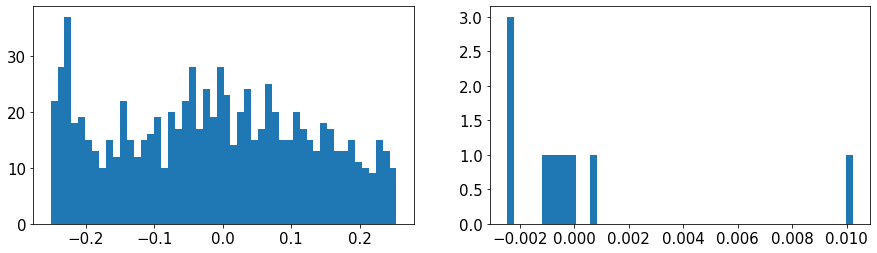

In [2424]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.hist(W.flatten(), 50);
plt.subplot(122)
plt.hist(W[-1,:], 50);

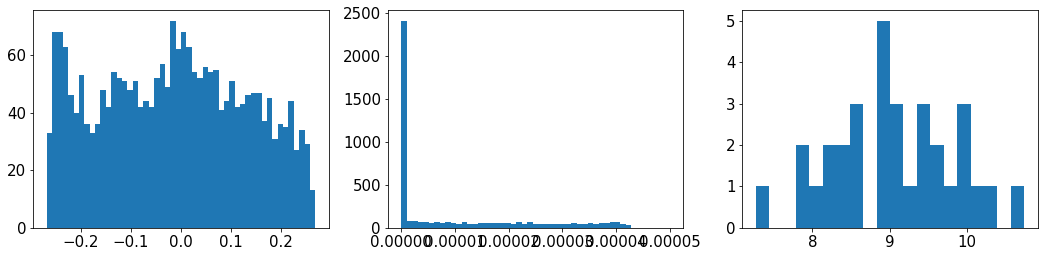

In [2079]:
plt.figure(figsize=(18,4))
plt.subplot(131)
plt.hist(W.flatten(), 50);
plt.subplot(132)
plt.hist(G.flatten(), np.linspace(0, 5e-5, 50));
plt.subplot(133)
plt.hist(np.sum(np.abs(W), axis=0), 20);

In [2375]:
spi.enable_single_core(dev, core_row, core_col)
wupdate.write_reg(dev, 0, 0, core_row, core_col)
adc.adc_setup(dev, vread=1.1, vref=0.9)
reads1 = adc.read_average_resistance(dev, vread=1.1, vref=0.9, t_shld=100, t_delta=200,
                                     read_cycles=10, ignore_cycles=5, verbose=False)
print(reads1)

348166.09290662594


In [2370]:
wupdate.apply_set_pulse(dev, 2.0, 3.0, 1e-6, prep=True)

In [2374]:
wupdate.apply_reset_pulse(dev, 4.0, 1e-6, prep=True)

In [3249]:
adc.adc_setup(dev, vread=1.1, vref=0.9)
spi.enable_single_core(dev, core_row, core_col)
program_sucess, G_program, num_pulses, pulses = wupdate.program_array(
    dev, rows, cols, core_row, core_col, G, g_min, g_tol, 1, end_voltage=4.0, vread=1.1, vref=0.9, vset_wl=3.0, iteration_limit=50, record_pulse=False, verbose=1)

RRAM is programmed within the range.
Finished programming 0 row 20 col
RRAM is programmed within the range.
Finished programming 0 row 21 col
RRAM is programmed within the range.
Finished programming 0 row 22 col
RRAM is programmed within the range.
Finished programming 0 row 23 col
RRAM is programmed within the range.
Finished programming 0 row 24 col
RRAM is programmed within the range.
Finished programming 0 row 25 col
RRAM is programmed within the range.
Finished programming 0 row 26 col
RRAM is programmed within the range.
Finished programming 0 row 27 col
RRAM is programmed within the range.
Finished programming 0 row 28 col
RRAM is programmed within the range.
Finished programming 0 row 29 col
RRAM is programmed within the range.
Finished programming 1 row 20 col
RRAM is programmed within the range.
Finished programming 1 row 21 col
RRAM is programmed within the range.
Finished programming 1 row 22 col
RRAM is programmed within the range.
Finished programming 1 row 23 col
RRAM i

RRAM is programmed within the range.
Finished programming 14 row 28 col
RRAM is programmed within the range.
Finished programming 14 row 29 col
RRAM is programmed within the range.
Finished programming 18 row 20 col
RRAM is programmed within the range.
Finished programming 18 row 21 col
RRAM is programmed within the range.
Finished programming 18 row 22 col
RRAM is programmed within the range.
Finished programming 18 row 23 col
RRAM is programmed within the range.
Finished programming 18 row 24 col
RRAM is programmed within the range.
Finished programming 18 row 25 col
RRAM is programmed within the range.
Finished programming 18 row 26 col
RRAM is programmed within the range.
Finished programming 18 row 27 col
RRAM is programmed within the range.
Finished programming 18 row 28 col
RRAM is programmed within the range.
Finished programming 18 row 29 col
RRAM is programmed within the range.
Finished programming 19 row 20 col
RRAM is programmed within the range.
Finished programming 19 row

RRAM is programmed within the range.
Finished programming 32 row 24 col
RRAM is programmed within the range.
Finished programming 32 row 25 col
RRAM is programmed within the range.
Finished programming 32 row 26 col
RRAM is programmed within the range.
Finished programming 32 row 27 col
RRAM is programmed within the range.
Finished programming 32 row 28 col
RRAM is programmed within the range.
Finished programming 32 row 29 col
RRAM is programmed within the range.
Finished programming 34 row 20 col
RRAM is programmed within the range.
Finished programming 34 row 21 col
RRAM is programmed within the range.
Finished programming 34 row 22 col
RRAM is programmed within the range.
Finished programming 34 row 23 col
RRAM is programmed within the range.
Finished programming 34 row 24 col
RRAM is programmed within the range.
Finished programming 34 row 25 col
RRAM is programmed within the range.
Finished programming 34 row 26 col
RRAM is programmed within the range.
Finished programming 34 row

RRAM is programmed within the range.
Finished programming 46 row 29 col
RRAM is programmed within the range.
Finished programming 47 row 20 col
RRAM is programmed within the range.
Finished programming 47 row 21 col
RRAM is programmed within the range.
Finished programming 47 row 22 col
RRAM is programmed within the range.
Finished programming 47 row 23 col
RRAM is programmed within the range.
Finished programming 47 row 24 col
RRAM is programmed within the range.
Finished programming 47 row 25 col
RRAM is programmed within the range.
Finished programming 47 row 26 col
RRAM is programmed within the range.
Finished programming 47 row 27 col
RRAM is programmed within the range.
Finished programming 47 row 28 col
RRAM is programmed within the range.
Finished programming 47 row 29 col
RRAM is programmed within the range.
Finished programming 48 row 20 col
RRAM is programmed within the range.
Finished programming 48 row 21 col
RRAM is programmed within the range.
Finished programming 48 row

RRAM is programmed within the range.
Finished programming 61 row 26 col
RRAM is programmed within the range.
Finished programming 61 row 27 col
RRAM is programmed within the range.
Finished programming 61 row 28 col
RRAM is programmed within the range.
Finished programming 61 row 29 col
RRAM is programmed within the range.
Finished programming 62 row 20 col
RRAM is programmed within the range.
Finished programming 62 row 21 col
RRAM is programmed within the range.
Finished programming 62 row 22 col
RRAM is programmed within the range.
Finished programming 62 row 23 col
RRAM is programmed within the range.
Finished programming 62 row 24 col
RRAM is programmed within the range.
Finished programming 62 row 25 col
RRAM is programmed within the range.
Finished programming 62 row 26 col
RRAM is programmed within the range.
Finished programming 62 row 27 col
RRAM is programmed within the range.
Finished programming 62 row 28 col
RRAM is programmed within the range.
Finished programming 62 row

RRAM is programmed within the range.
Finished programming 78 row 20 col
RRAM is programmed within the range.
Finished programming 78 row 21 col
RRAM is programmed within the range.
Finished programming 78 row 22 col
RRAM is programmed within the range.
Finished programming 78 row 23 col
RRAM is programmed within the range.
Finished programming 78 row 24 col
RRAM is programmed within the range.
Finished programming 78 row 25 col
RRAM is programmed within the range.
Finished programming 78 row 26 col
RRAM is programmed within the range.
Finished programming 78 row 27 col
RRAM is programmed within the range.
Finished programming 78 row 28 col
RRAM is programmed within the range.
Finished programming 78 row 29 col
RRAM is programmed within the range.
Finished programming 79 row 20 col
RRAM is programmed within the range.
Finished programming 79 row 21 col
RRAM is programmed within the range.
Finished programming 79 row 22 col
RRAM is programmed within the range.
Finished programming 79 row

RRAM is programmed within the range.
Finished programming 91 row 26 col
RRAM is programmed within the range.
Finished programming 91 row 27 col
RRAM is programmed within the range.
Finished programming 91 row 28 col
RRAM is programmed within the range.
Finished programming 91 row 29 col
RRAM is programmed within the range.
Finished programming 92 row 20 col
RRAM is programmed within the range.
Finished programming 92 row 21 col
RRAM is programmed within the range.
Finished programming 92 row 22 col
RRAM is programmed within the range.
Finished programming 92 row 23 col
RRAM is programmed within the range.
Finished programming 92 row 24 col
RRAM is programmed within the range.
Finished programming 92 row 25 col
RRAM is programmed within the range.
Finished programming 92 row 26 col
RRAM is programmed within the range.
Finished programming 92 row 27 col
RRAM is programmed within the range.
Finished programming 92 row 28 col
RRAM is programmed within the range.
Finished programming 92 row

RRAM is programmed within the range.
Finished programming 110 row 20 col
RRAM is programmed within the range.
Finished programming 110 row 21 col
RRAM is programmed within the range.
Finished programming 110 row 22 col
RRAM is programmed within the range.
Finished programming 110 row 23 col
RRAM is programmed within the range.
Finished programming 110 row 24 col
RRAM is programmed within the range.
Finished programming 110 row 25 col
RRAM is programmed within the range.
Finished programming 110 row 26 col
RRAM is programmed within the range.
Finished programming 110 row 27 col
RRAM is programmed within the range.
Finished programming 110 row 28 col
RRAM is programmed within the range.
Finished programming 110 row 29 col
RRAM is programmed within the range.
Finished programming 111 row 20 col
RRAM is programmed within the range.
Finished programming 111 row 21 col
RRAM is programmed within the range.
Finished programming 111 row 22 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 123 row 24 col
RRAM is programmed within the range.
Finished programming 123 row 25 col
RRAM is programmed within the range.
Finished programming 123 row 26 col
RRAM is programmed within the range.
Finished programming 123 row 27 col
RRAM is programmed within the range.
Finished programming 123 row 28 col
RRAM is programmed within the range.
Finished programming 123 row 29 col
RRAM is programmed within the range.
Finished programming 124 row 20 col
RRAM is programmed within the range.
Finished programming 124 row 21 col
RRAM is programmed within the range.
Finished programming 124 row 22 col
RRAM is programmed within the range.
Finished programming 124 row 23 col
RRAM is programmed within the range.
Finished programming 124 row 24 col
RRAM is programmed within the range.
Finished programming 124 row 25 col
RRAM is programmed within the range.
Finished programming 124 row 26 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 138 row 27 col
RRAM is programmed within the range.
Finished programming 138 row 28 col
RRAM is programmed within the range.
Finished programming 138 row 29 col
RRAM is programmed within the range.
Finished programming 139 row 20 col
RRAM is programmed within the range.
Finished programming 139 row 21 col
RRAM is programmed within the range.
Finished programming 139 row 22 col
RRAM is programmed within the range.
Finished programming 139 row 23 col
RRAM is programmed within the range.
Finished programming 139 row 24 col
RRAM is programmed within the range.
Finished programming 139 row 25 col
RRAM is programmed within the range.
Finished programming 139 row 26 col
RRAM is programmed within the range.
Finished programming 139 row 27 col
RRAM is programmed within the range.
Finished programming 139 row 28 col
RRAM is programmed within the range.
Finished programming 139 row 29 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 155 row 20 col
RRAM is programmed within the range.
Finished programming 155 row 21 col
RRAM is programmed within the range.
Finished programming 155 row 22 col
RRAM is programmed within the range.
Finished programming 155 row 23 col
RRAM is programmed within the range.
Finished programming 155 row 24 col
RRAM is programmed within the range.
Finished programming 155 row 25 col
RRAM is programmed within the range.
Finished programming 155 row 26 col
RRAM is programmed within the range.
Finished programming 155 row 27 col
RRAM is programmed within the range.
Finished programming 155 row 28 col
RRAM is programmed within the range.
Finished programming 155 row 29 col
RRAM is programmed within the range.
Finished programming 156 row 20 col
RRAM is programmed within the range.
Finished programming 156 row 21 col
RRAM is programmed within the range.
Finished programming 156 row 22 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 171 row 24 col
RRAM is programmed within the range.
Finished programming 171 row 25 col
RRAM is programmed within the range.
Finished programming 171 row 26 col
RRAM is programmed within the range.
Finished programming 171 row 27 col
RRAM is programmed within the range.
Finished programming 171 row 28 col
RRAM is programmed within the range.
Finished programming 171 row 29 col
RRAM is programmed within the range.
Finished programming 172 row 20 col
RRAM is programmed within the range.
Finished programming 172 row 21 col
RRAM is programmed within the range.
Finished programming 172 row 22 col
RRAM is programmed within the range.
Finished programming 172 row 23 col
RRAM is programmed within the range.
Finished programming 172 row 24 col
RRAM is programmed within the range.
Finished programming 172 row 25 col
RRAM is programmed within the range.
Finished programming 172 row 26 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 184 row 28 col
RRAM is programmed within the range.
Finished programming 184 row 29 col
RRAM is programmed within the range.
Finished programming 185 row 20 col
RRAM is programmed within the range.
Finished programming 185 row 21 col
RRAM is programmed within the range.
Finished programming 185 row 22 col
RRAM is programmed within the range.
Finished programming 185 row 23 col
RRAM is programmed within the range.
Finished programming 185 row 24 col
RRAM is programmed within the range.
Finished programming 185 row 25 col
RRAM is programmed within the range.
Finished programming 185 row 26 col
RRAM is programmed within the range.
Finished programming 185 row 27 col
RRAM is programmed within the range.
Finished programming 185 row 28 col
RRAM is programmed within the range.
Finished programming 185 row 29 col
RRAM is programmed within the range.
Finished programming 186 row 20 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 197 row 22 col
RRAM is programmed within the range.
Finished programming 197 row 23 col
RRAM is programmed within the range.
Finished programming 197 row 24 col
RRAM is programmed within the range.
Finished programming 197 row 25 col
RRAM is programmed within the range.
Finished programming 197 row 26 col
RRAM is programmed within the range.
Finished programming 197 row 27 col
RRAM is programmed within the range.
Finished programming 197 row 28 col
RRAM is programmed within the range.
Finished programming 197 row 29 col
RRAM is programmed within the range.
Finished programming 198 row 20 col
RRAM is programmed within the range.
Finished programming 198 row 21 col
RRAM is programmed within the range.
Finished programming 198 row 22 col
RRAM is programmed within the range.
Finished programming 198 row 23 col
RRAM is programmed within the range.
Finished programming 198 row 24 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 209 row 28 col
RRAM is programmed within the range.
Finished programming 209 row 29 col
RRAM is programmed within the range.
Finished programming 211 row 20 col
RRAM is programmed within the range.
Finished programming 211 row 21 col
RRAM is programmed within the range.
Finished programming 211 row 22 col
RRAM is programmed within the range.
Finished programming 211 row 23 col
RRAM is programmed within the range.
Finished programming 211 row 24 col
RRAM is programmed within the range.
Finished programming 211 row 25 col
RRAM is programmed within the range.
Finished programming 211 row 26 col
RRAM is programmed within the range.
Finished programming 211 row 27 col
RRAM is programmed within the range.
Finished programming 211 row 28 col
RRAM is programmed within the range.
Finished programming 211 row 29 col
RRAM is programmed within the range.
Finished programming 212 row 20 col
RRAM is programmed within the range.
Finished progr

In [3250]:
print(np.sum(~program_sucess)/program_sucess.size)
print(np.argwhere(~program_sucess))
print(G[~program_sucess])
print(G_program[~program_sucess])

0.0018072289156626507
[[109   9]
 [142   4]
 [144   8]]
[ 3.93572445e-05  3.64693551e-05 -0.00000000e+00]
[2.32998657e-05 2.34344482e-05 3.59439850e-06]


# Matmul Calibration

In [3251]:
# Single Core

ITERATION = 2000
INPUT_NUM_BITS = 3
BATCH = 10
vpos = 0.53 #0.31
vneg = 0.47 #0.22
vreset_plus = 0.12 #0.17
vreset_minus = 0.04 #0.08
pulse_multiplier = 4
matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)
spi.enable_single_core(dev, core_row, core_col)
# inputs = np.floor(np.random.uniform(0, 2**INPUT_NUM_BITS, size=[ITERATION, len(rows)//2]))
inputs = input_sample[:ITERATION, :].reshape([ITERATION, -1])
bias = 7 * np.ones([ITERATION, 1])
inputs = np.hstack([inputs[:, np.arange(86*4, 86*4 + 82)], bias])

actual_outputs = np.zeros([ITERATION, len(cols)])
expected_outputs = inputs.dot(W)
start = time.time()

for i in range(ITERATION//BATCH):
    actual_outputs[BATCH*i:BATCH*(i+1), :] = matmul.matmul_unsigned(dev, inputs[BATCH*i:BATCH*(i+1), :], rows, cols, False, core_row, True, INPUT_NUM_BITS, core_col, pulse_multiplier=pulse_multiplier, prep=(i==0))

end = time.time()
print(end-start)
matmul.disable_inference(dev)

2.370152473449707


In [3252]:
slope = np.zeros(W.shape[1])
intercept = np.zeros(W.shape[1])
for c in range(W.shape[1]):
    p, res, _, _, _ = np.polyfit(expected_outputs[:, c], actual_outputs[:, c], 1, full=True)
    slope[c] = p[0]
    intercept[c] = p[1]
    actual_outputs[:, c] = (actual_outputs[:, c] - p[1]) / p[0]

In [3235]:
expected_outputs = expected_outputs = inputs.dot(W)
expected_outputs_all = expected_outputs
actual_outputs_all = actual_outputs

In [3237]:
expected_outputs = expected_outputs_all
actual_outputs = actual_outputs_all

0.3040140525099232


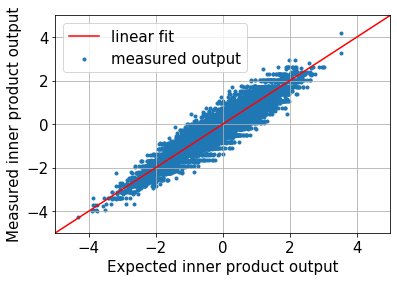

In [3253]:
for c in range(1):
#     expected_outputs = expected_outputs_all[:, c]
#     actual_outputs = actual_outputs_all[:, c]

    expected_outputs = expected_outputs / np.linalg.norm(expected_outputs) * np.sqrt(expected_outputs.size)
    p, res, _, _, _ = np.polyfit(expected_outputs.flatten(), actual_outputs.flatten(), 1, full=True)
    y_fit = np.poly1d(p)
    std = np.sqrt(res/(expected_outputs.size-1))
    x = np.arange(-40, 40, 0.1)

    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(6,4))
    plt.scatter(expected_outputs, actual_outputs/p[0], label='measured output', marker='.')
    plt.plot(x, y_fit(x)/p[0], 'r', label='linear fit')
    plt.grid()
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.xlabel('Expected inner product output')
    plt.ylabel('Measured inner product output')
    plt.legend()


#     print(p[0])
    print(std[0]/p[0])

6.211817993386016
6.510850430867458


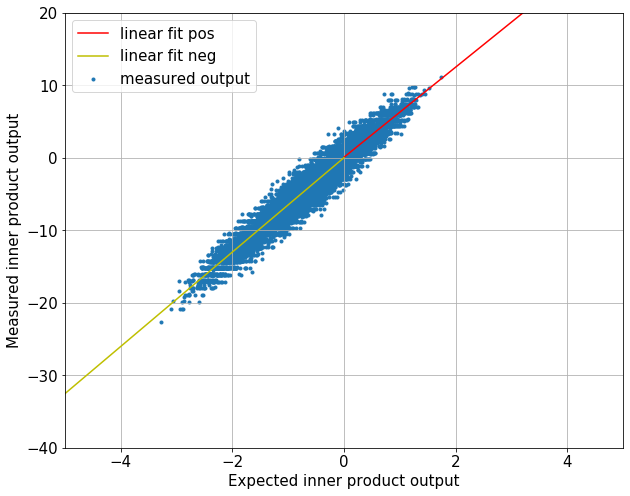

In [1054]:
# Calibrate reset voltage
linear = lambda x, k: x*k

mask_pos = expected_outputs > 0
mask_neg = ~mask_pos

p1, _, _, _, _ = np.polyfit(expected_outputs[mask_pos].flatten(), actual_outputs[mask_pos].flatten(), 1, full=True)
y_fit_1 = np.poly1d(p1)
x1 = np.linspace(0, 40, 10)

p2, _, _, _, _ = np.polyfit(expected_outputs[mask_neg].flatten(), actual_outputs[mask_neg].flatten(), 1, full=True)
y_fit_2 = np.poly1d(p2)
x2 = np.linspace(-40, 0, 10)

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 15})
ax = plt.subplot(111)
plt.scatter(expected_outputs, actual_outputs, label='measured output', marker='.')
plt.plot(x1, y_fit_1(x1), 'r', label='linear fit pos')
plt.plot(x2, y_fit_2(x2), 'y', label='linear fit neg')
plt.grid()
plt.xlim(-5, 5)
plt.ylim(-40, 20)
plt.xlabel('Expected inner product output')
plt.ylabel('Measured inner product output')
plt.legend()

print(p1[0])
print(p2[0])

# Inference

In [2975]:
DATA_PATH = 'C:\\Users\\Weier Wan\\Documents\\neurram_data\\mnist_cnn_7layer\\'

tmp = np.load(DATA_PATH + 'conv2d_noise_4_0_all.npz')
out_chip_0 = tmp['out_chip']
slope_0 = tmp['slope']
intercept_0 = tmp['intercept']

tmp = np.load(DATA_PATH + 'conv2d_noise_4_1_all.npz')
out_chip_1 = tmp['out_chip']
slope_1 = tmp['slope']
intercept_1 = tmp['intercept']

previous_layer = (out_chip_0 - intercept_0) / slope_0 + (out_chip_1 - intercept_1) / slope_1

In [3051]:
# input_sample = nn_np.quantize_unsigned(x_test[:, :, :, :], 3, 1)
input_sample = nn_np.quantize_unsigned(previous_layer, 3, relux)
input_rescale = nn_np.quantize_rescale(input_sample, 3, relux)

In [3254]:
# vpos = 0.32
# vneg = 0.28
# vreset_plus = 0.17
# vreset_minus = 0.08
# pulse_multiplier = 4

start = time.time()
matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)
spi.enable_single_core(dev, core_row, core_col)
# out_chip = nn.conv_unsigned(dev, input_sample, rows, cols, core_row, core_col, 3, 3, 3, segment_index=np.arange(96, 192), pad=(1,1), bias=True, batch_size=10, pulse_multiplier=pulse_multiplier, verbose=True)
out_chip = nn.dense_unsigned(dev, input_sample, rows, cols, core_row, core_col, 3, segment_index=np.arange(86*5, 86*5+82), bias=True, batch_size=10, pulse_multiplier=pulse_multiplier, verbose=True)
# out_chip = quantize_rescale(out_chip, 3, relux1)
end = time.time()
print(end-start)

Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished batch 10
Finished batch 11
Finished batch 12
Finished batch 13
Finished batch 14
Finished batch 15
Finished batch 16
Finished batch 17
Finished batch 18
Finished batch 19
Finished batch 20
Finished batch 21
Finished batch 22
Finished batch 23
Finished batch 24
Finished batch 25
Finished batch 26
Finished batch 27
Finished batch 28
Finished batch 29
Finished batch 30
Finished batch 31
Finished batch 32
Finished batch 33
Finished batch 34
Finished batch 35
Finished batch 36
Finished batch 37
Finished batch 38
Finished batch 39
Finished batch 40
Finished batch 41
Finished batch 42
Finished batch 43
Finished batch 44
Finished batch 45
Finished batch 46
Finished batch 47
Finished batch 48
Finished batch 49
Finished batch 50
Finished batch 51
Finished batch 52
Finished batch 53
Finished batch 54
Finished batch 55
Fi

Finished batch 452
Finished batch 453
Finished batch 454
Finished batch 455
Finished batch 456
Finished batch 457
Finished batch 458
Finished batch 459
Finished batch 460
Finished batch 461
Finished batch 462
Finished batch 463
Finished batch 464
Finished batch 465
Finished batch 466
Finished batch 467
Finished batch 468
Finished batch 469
Finished batch 470
Finished batch 471
Finished batch 472
Finished batch 473
Finished batch 474
Finished batch 475
Finished batch 476
Finished batch 477
Finished batch 478
Finished batch 479
Finished batch 480
Finished batch 481
Finished batch 482
Finished batch 483
Finished batch 484
Finished batch 485
Finished batch 486
Finished batch 487
Finished batch 488
Finished batch 489
Finished batch 490
Finished batch 491
Finished batch 492
Finished batch 493
Finished batch 494
Finished batch 495
Finished batch 496
Finished batch 497
Finished batch 498
Finished batch 499
Finished batch 500
Finished batch 501
Finished batch 502
Finished batch 503
Finished bat

Finished batch 891
Finished batch 892
Finished batch 893
Finished batch 894
Finished batch 895
Finished batch 896
Finished batch 897
Finished batch 898
Finished batch 899
Finished batch 900
Finished batch 901
Finished batch 902
Finished batch 903
Finished batch 904
Finished batch 905
Finished batch 906
Finished batch 907
Finished batch 908
Finished batch 909
Finished batch 910
Finished batch 911
Finished batch 912
Finished batch 913
Finished batch 914
Finished batch 915
Finished batch 916
Finished batch 917
Finished batch 918
Finished batch 919
Finished batch 920
Finished batch 921
Finished batch 922
Finished batch 923
Finished batch 924
Finished batch 925
Finished batch 926
Finished batch 927
Finished batch 928
Finished batch 929
Finished batch 930
Finished batch 931
Finished batch 932
Finished batch 933
Finished batch 934
Finished batch 935
Finished batch 936
Finished batch 937
Finished batch 938
Finished batch 939
Finished batch 940
Finished batch 941
Finished batch 942
Finished bat

In [3255]:
# intermediate_output = nn_np.conv(input_rescale, params[layer][0], params[layer][1] / 3, stride=1, pad=(1,1),
#                                  segment_index=np.arange(96, 192), bias=True)
intermediate_output = nn_np.dense(input_rescale, params[layer][0], params[layer][1] / 6, segment_index=np.arange(86*5, 86*5+82))

In [1535]:
# intermediate_layer_model = keras.Model(inputs=model.input,
#                                  outputs=model.get_layer('conv2d_noise').output)
# intermediate_output = intermediate_layer_model.predict(input_rescale)

In [3256]:
slope = np.zeros(W.shape[1])
intercept = np.zeros(W.shape[1])
out_chip_shift = np.copy(out_chip)
for c in range(W.shape[1]):
    p, res, _, _, _ = np.polyfit(intermediate_output[:, c].flatten(), out_chip[:, c].flatten(), 1, full=True)
    slope[c] = p[0]
    intercept[c] = p[1]
    out_chip_shift[:, c] = (out_chip_shift[:, c] - p[1]) / p[0]

0.342801859538324
0.292673500297881
0.29801889527274505
0.2971791991185222
0.32183393169514163
0.2723947147738046
0.3190958324239477
0.2959013953669414
0.19941942954539846
0.3350188140686235


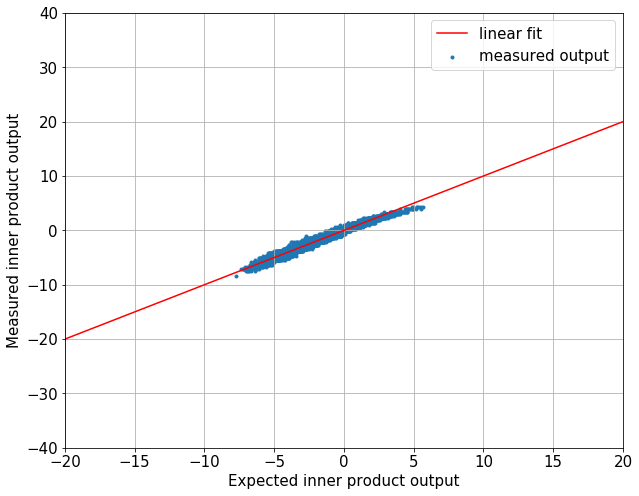

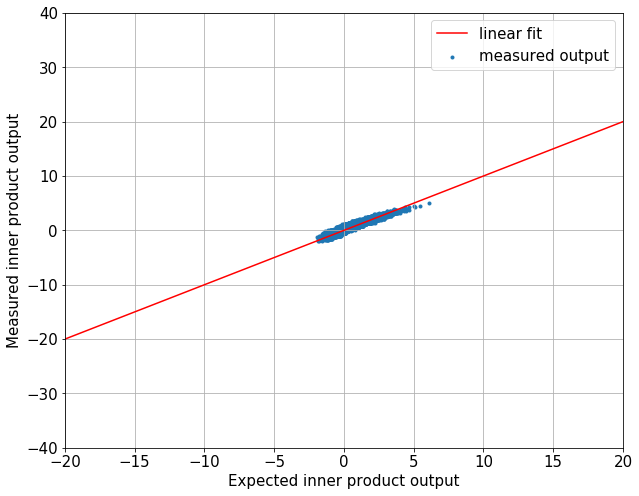

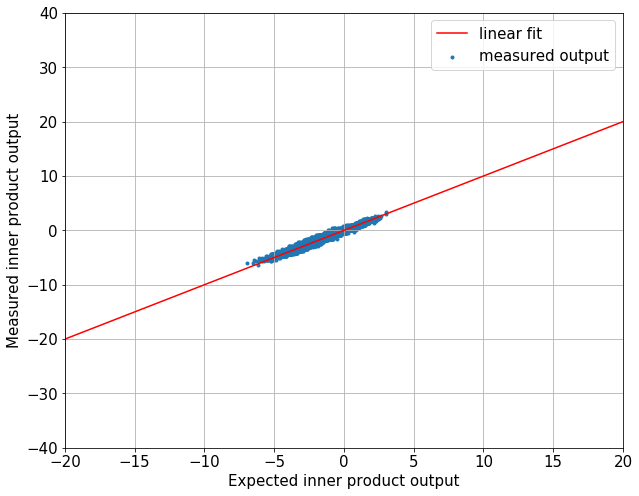

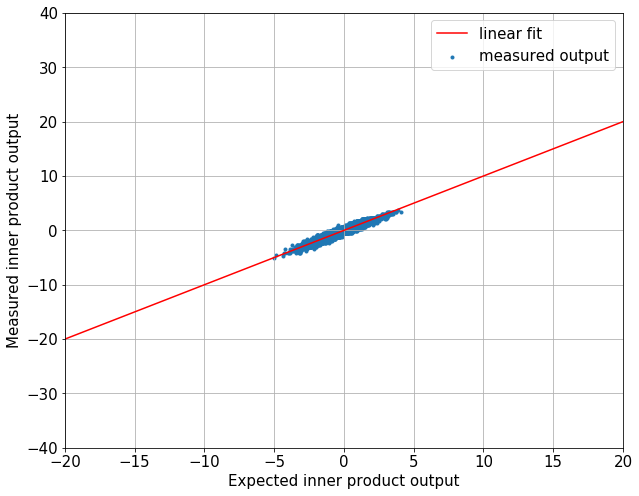

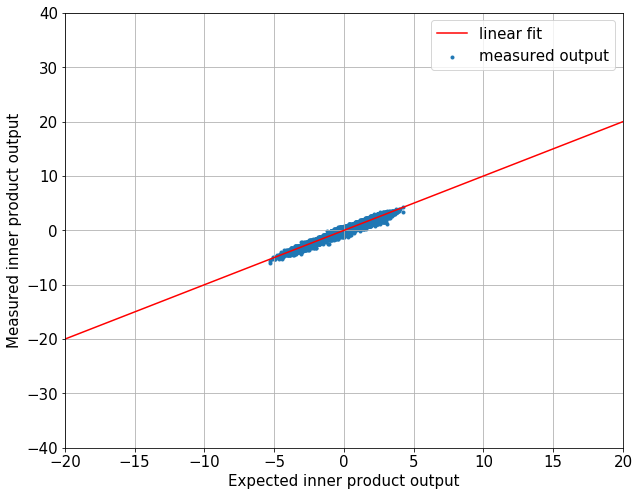

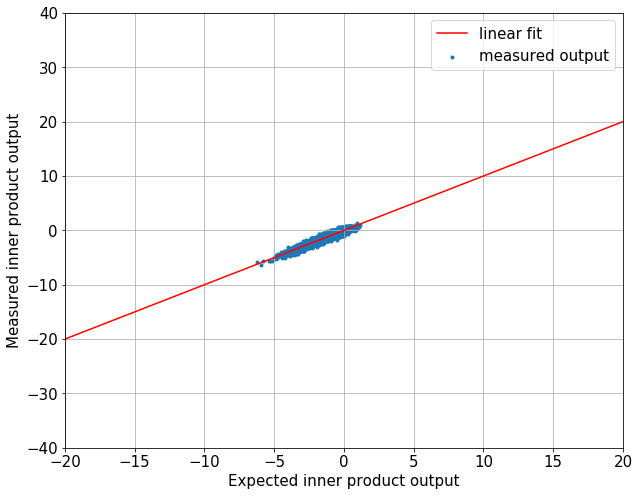

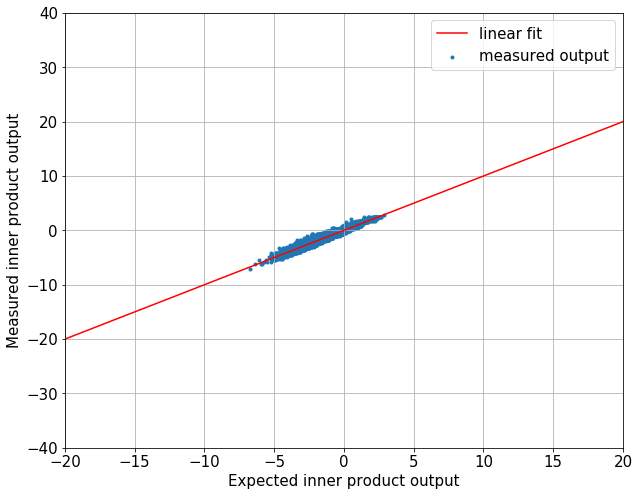

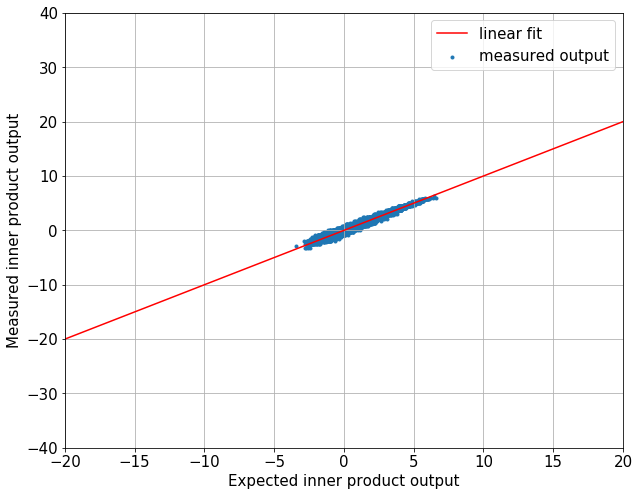

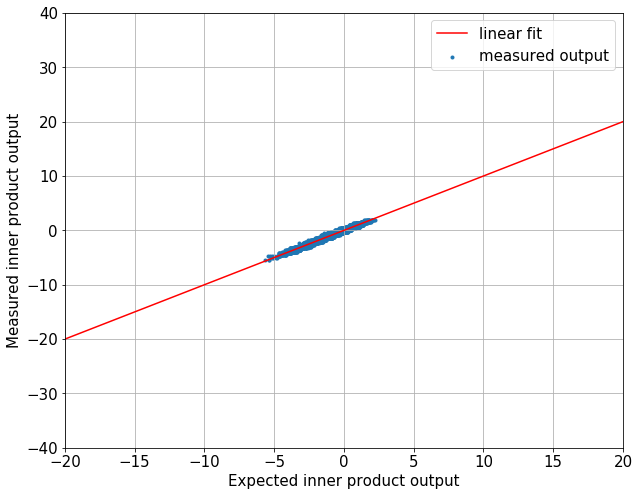

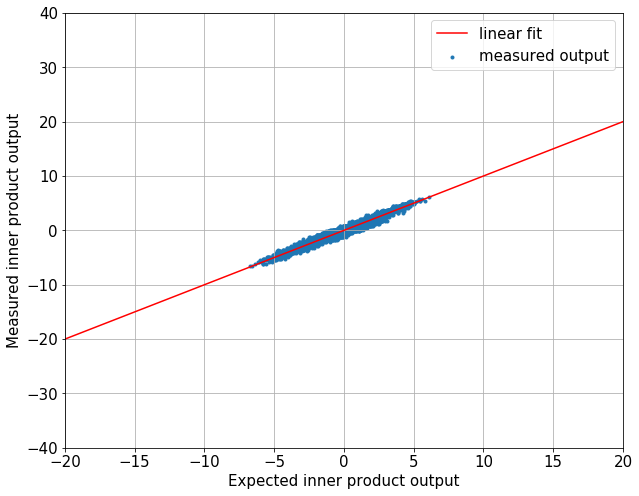

In [3257]:
for c in range(W.shape[1]):
    p, res, _, _, _ = np.polyfit(intermediate_output[:, c].flatten(), out_chip_shift[:, c].flatten(), 1, full=True)
    y_fit = np.poly1d(p)
    std = np.sqrt(res/(intermediate_output[:, c].size-1))
    x = np.arange(-100, 100, 1)

    plt.figure(figsize=(10,8))
    plt.rcParams.update({'font.size': 15})
    ax = plt.subplot(111)
    plt.scatter(intermediate_output[:, c], out_chip_shift[:, c], label='measured output', marker='.')
    plt.plot(x, y_fit(x), 'r', label='linear fit')
    plt.grid()
    plt.xlim(-20, 20)
    plt.ylim(-40, 40)
    plt.xlabel('Expected inner product output')
    plt.ylabel('Measured inner product output')
    plt.legend()

#     print(p[0]) # This is the output scaling factor
    print(std[0]/p[0])

In [3258]:
np.savez(DATA_PATH + '%s_5_largeV' % layer, out_chip=out_chip, slope=slope, intercept=intercept)

# Evaluate Inference Accuracy

In [2971]:
K.clear_session()

new_model = Sequential()
# new_model.add(conv2d_noise(8, padding='same', name='conv2d_noise', input_shape=input_shape))
# new_model.add(activation_quant(3, 3, name='activation_quant'))
# new_model.add(conv2d_noise(8, padding='same', name='conv2d_noise_1'))
# new_model.add(MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pooling2d'))
# new_model.add(activation_quant(3, 3, name='activation_quant_1'))
# new_model.add(conv2d_noise(16, padding='same', name='conv2d_noise_2'))
# new_model.add(activation_quant(3, 3, name='activation_quant_2'))
# new_model.add(conv2d_noise(16, padding='same', name='conv2d_noise_3'))
# new_model.add(MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pooling2d_1'))
# new_model.add(activation_quant(3, 3, name='activation_quant_3'))
# new_model.add(conv2d_noise(32, padding='same', name='conv2d_noise_4',))
# new_model.add(activation_quant(3, 3, name='activation_quant_4'))
# new_model.add(conv2d_noise(32, padding='same', name='conv2d_noise_5',))
new_model.add(MaxPooling2D(pool_size=(2, 2), padding='same', name='max_pooling2d_2', input_shape=(7,7,32)))
new_model.add(Flatten())
new_model.add(activation_quant(3, 3, name='activation_quant_5'))
new_model.add(dense_noise(num_classes, activation='softmax', name='dense'))

new_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
activation_quant_5 (activati (None, 512)               1         
_________________________________________________________________
dense (dense_noise)          (None, 10)                5130      
Total params: 5,131
Trainable params: 5,131
Non-trainable params: 0
_________________________________________________________________


In [2972]:
for model_layer in new_model.layers:
    model_layer.set_weights(params[model_layer.name])

In [3259]:
tmp = np.load(DATA_PATH + 'dense_0_largeV.npz')
out_chip_0 = tmp['out_chip']
slope_0 = tmp['slope']
intercept_0 = tmp['intercept']

tmp = np.load(DATA_PATH + 'dense_1_largeV.npz')
out_chip_1 = tmp['out_chip']
slope_1 = tmp['slope']
intercept_1 = tmp['intercept']

tmp = np.load(DATA_PATH + 'dense_2_largeV.npz')
out_chip_2 = tmp['out_chip']
slope_2 = tmp['slope']
intercept_2 = tmp['intercept']

tmp = np.load(DATA_PATH + 'dense_3_largeV.npz')
out_chip_3 = tmp['out_chip']
slope_3 = tmp['slope']
intercept_3 = tmp['intercept']

tmp = np.load(DATA_PATH + 'dense_4_largeV.npz')
out_chip_4 = tmp['out_chip']
slope_4 = tmp['slope']
intercept_4 = tmp['intercept']

tmp = np.load(DATA_PATH + 'dense_5_largeV.npz')
out_chip_5 = tmp['out_chip']
slope_5 = tmp['slope']
intercept_5 = tmp['intercept']

current_layer = (out_chip_0 - intercept_0) / slope_0 + (out_chip_1 - intercept_1) / slope_1 + (out_chip_2 - intercept_2) / slope_2 + (out_chip_3 - intercept_3) / slope_3 + (out_chip_4 - intercept_4) / slope_4 + (out_chip_5 - intercept_5) / slope_5

In [3048]:
# Score intermediate input model.
scores = new_model.evaluate(current_layer, y_test[:, :], verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 75us/sample - loss: 0.0376 - accuracy: 0.9895
Test loss: 0.03764717663522497
Test accuracy: 0.9895


In [3049]:
intermediate_layer_model = keras.Model(inputs=new_model.input,
                                 outputs=new_model.get_layer('flatten').output)
intermediate_output = intermediate_layer_model.predict(current_layer)

In [3260]:
np.sum(np.argmax(current_layer, axis=1) == np.argmax(y_test[:, :], axis=1)) / 10000

0.9902